In [52]:
 ! pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-09-09 20:40:01          11912  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           7247  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2844  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2854  
nickuzmenkov/nih

In [6]:
!kaggle datasets download -d trisha2094/weatheraus

  0% 0.00/3.87M [00:00<?, ?B/s]
100% 3.87M/3.87M [00:00<00:00, 64.0MB/s]


In [7]:
! unzip weatheraus.zip

Archive:  weatheraus.zip
  inflating: weatherAUS.csv          


<h1>Predicting rain in Australia</h1>

<h2>List of contents</h2>
1. Exploratory Data Analysis 
2. Data cleaning & feature extraction
3. Comparison of preprocessed data against original data
4. Model training
5. Model validation 


<h2>1. EDA - Exploratory Data Analysis </h2>
<h3> Preliminary data insight </h3>
Import libraries and load dataset:

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime

# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [55]:
# loading data
df = pd.read_csv('/content/weatherAUS.csv')

In [56]:
# check the head of dataset
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [57]:
# Check shape of dataset:rows ,columns
df.shape

(142193, 24)

In [58]:
# Checking the datatypes in file
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow      object
dtype: object

**We see that we have 24 variables including one target variable (RainTomorrow) and one variable that we should skip according to data description on kaggle (RAIN_MM).
Besides this we have 5 categorical variables: Location, WindGustDir, WindDir9am, WindDir3pm and RainToday (can also be considered as binary)
We also have Date it is not useful to predict any features. So, we can delete this.**


<h3> Target value insigths </h3>

**By taking RainTomorrow as target variable.**

In [59]:
# First - we check the distribution of the target(RainTomorrow) value
counts = df['RainTomorrow'].value_counts()
print(counts)

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64


In [60]:
#Checking the exact ratio of 'Yes' samples
print(np.sum(counts))
print(counts[1]/np.sum(counts))

142193
0.22418121848473554


We have ~22% samples with the 'Yes' output. So we have imbalanced dataset. Now let's check the distribution of the other values against the target value.
First numeric data.

<h3> Exploration of numeric variables </h3>

In [61]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
tmp = df.select_dtypes(include=numerics)
tmp["RainTomorrow"]= df["RainTomorrow"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


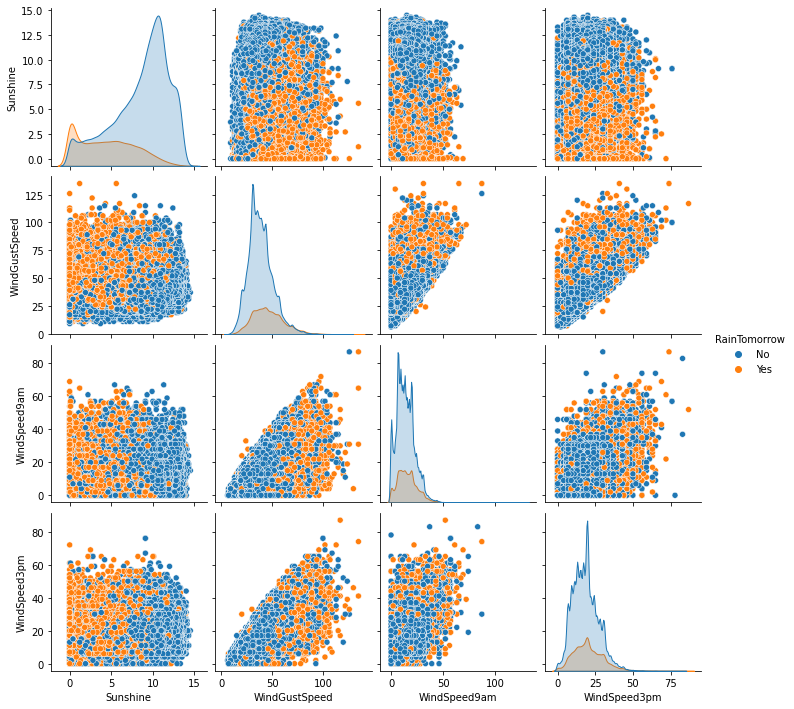

In [62]:
# checking distributions of first numerical values against target (cols 4-8):
sns.pairplot(tmp, vars = tmp.columns[4:8],hue="RainTomorrow")
plt.show()

From the figure above we see that 'Sunshine' may be good feature (peaks of 'No' and 'Yes' distributions are clearly separable)

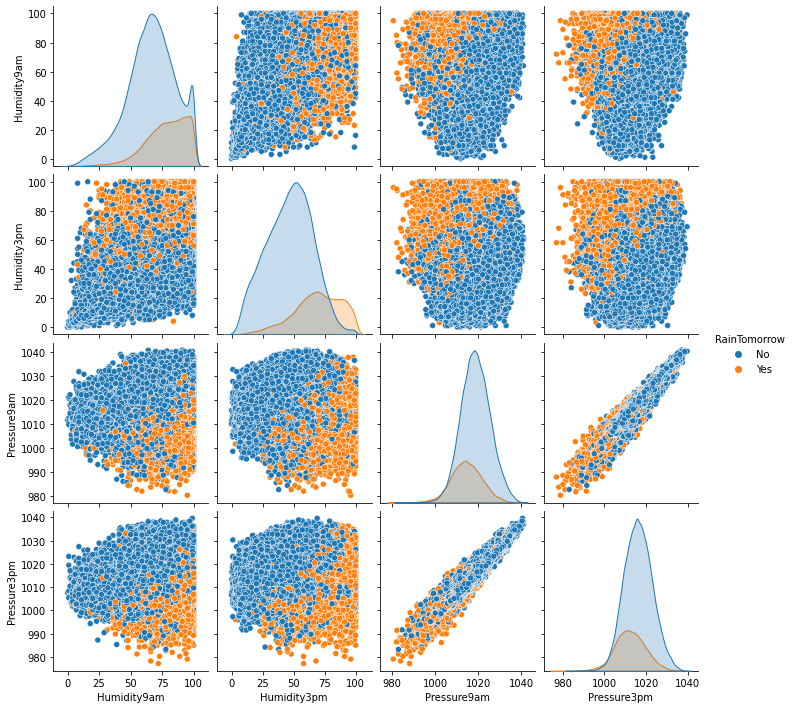

In [63]:
# checking distributions of first numerical values against target (cols 8-12):
sns.pairplot(tmp, vars = tmp.columns[8:12],hue="RainTomorrow")
plt.show()

Both hummudities show differences in distributions for our target value, also pressures have their distribution peaks slightly different. This probably makes them good feature to distinguish our target value. Pressures are also correlated with each other.

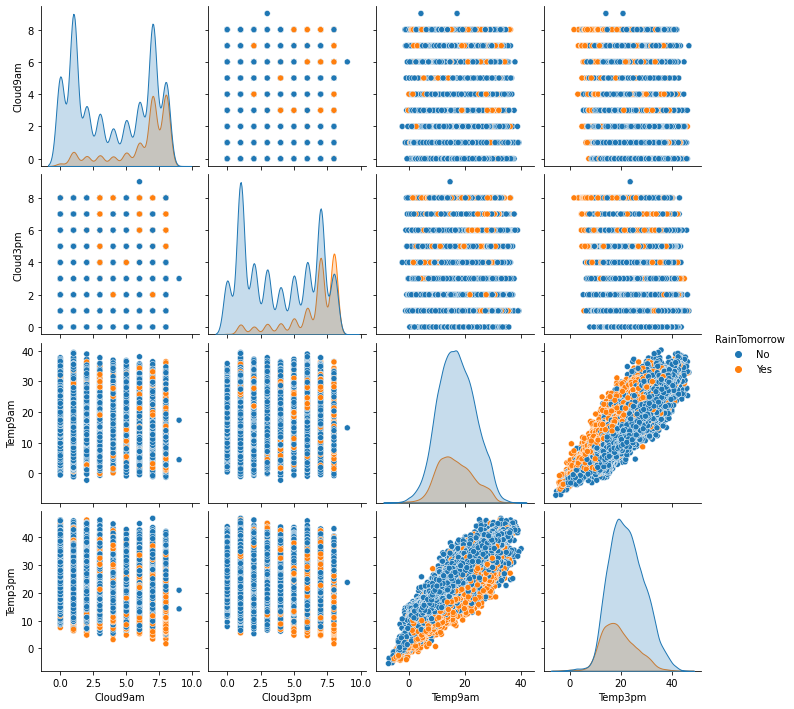

In [65]:
# checking distributions of first numerical values against target (cols 4-8):
sns.pairplot(tmp, vars = tmp.columns[12:16],hue="RainTomorrow")
plt.show()

We see that cloud features have good separation of distributions. Temperatures are correlated.

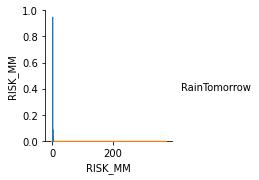

In [66]:
# Excluding the variable Risk-MM when training a binary classification model. 
# Not excluding it will leak the answers to your model and reduce its predictability.""
sns.pairplot(tmp, vars = tmp.columns[16:17],hue="RainTomorrow")
plt.show()

<h3> Exploration of non-numerical variables </h3>

We can see thaht in months 6 and 7 it rained more oftern than in other months.

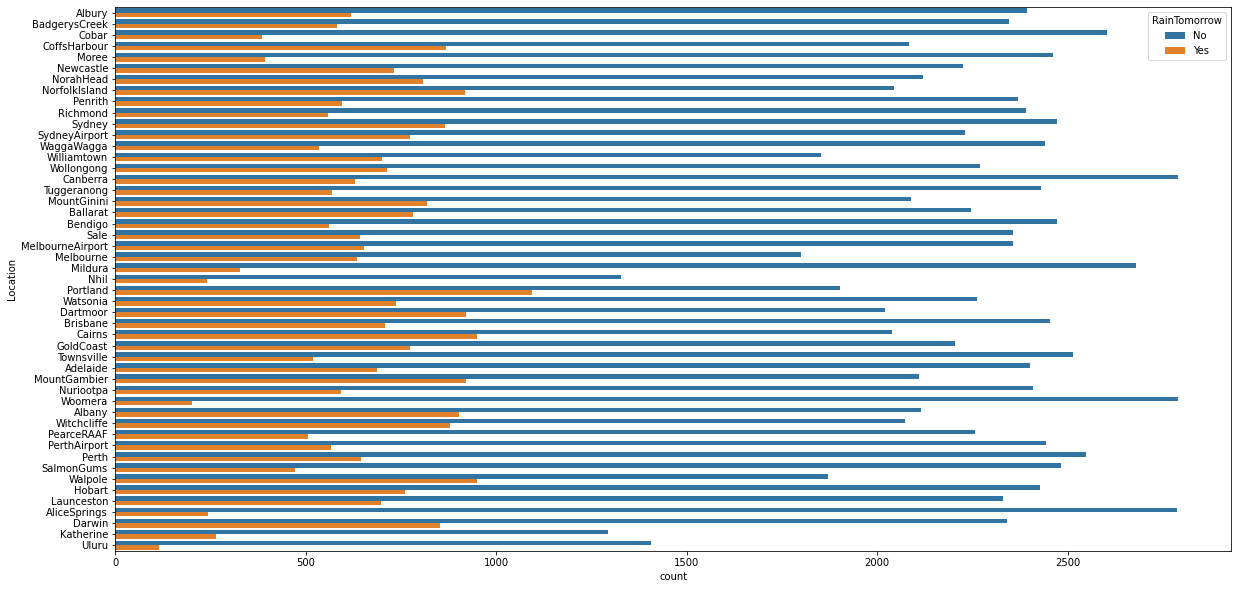

In [67]:
plt.figure(figsize=(20, 10))
sns.countplot(y = 'Location', hue =  'RainTomorrow', orient = 'h', data = df)

Checking cardinality and values counts:

In [68]:
len(df['Location'].unique())

49

In [69]:
df['Location'].value_counts()

Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Launceston          3028
Ballarat            3028
Albany              3016
Albury              3011
MelbourneAirport    3009
PerthAirport        3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cairns              2988
Cobar               2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
Penrith             2964
NorfolkIsland       2964
Newcastle           2955
SalmonGums          2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek       2928


So we have 49 unique values and the distribution is quite even. We can take this column as categorical.

Similar here - for example 'N'

Here we laso have to differences

Here we see that for most days if it was raining today - we also had rain tomorrow.

<h3> Data cleaning </h3>

In [70]:
# Droping the Date to not overfit the model to particular date and place:
df.drop(['Date'], axis=1, inplace = True)

#Excluding the variable Risk-MM when training a binary classification model. 
# Not excluding it will leak the answers to your model and reduce its predictability.""
df.drop(['RISK_MM'], axis=1, inplace = True)

In [71]:
# check % of missing data in columns
df.isnull().sum()/df.shape[0]*100

Location          0.000000
MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
RainToday         0.988797
RainTomorrow      0.000000
dtype: float64

In [72]:
# Evaporation, Sunshine Cloud 9 am and Cloud 3pm have a lot of missing data (above 30%)- we remove them:
df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1, inplace = True)
df.isnull().sum()/df.shape[0]*100

Location         0.000000
MinTemp          0.447983
MaxTemp          0.226453
Rainfall         0.988797
WindGustDir      6.561504
WindGustSpeed    6.519308
WindDir9am       7.041838
WindDir3pm       2.656952
WindSpeed9am     0.948007
WindSpeed3pm     1.849599
Humidity9am      1.247600
Humidity3pm      2.538803
Pressure9am      9.855619
Pressure3pm      9.832411
Temp9am          0.635756
Temp3pm          1.917113
RainToday        0.988797
RainTomorrow     0.000000
dtype: float64

In [73]:
df.shape

(142193, 18)

In [74]:
#replacing Na in numerical columns with mean for columns with Na ratio higher than 3%:
df['WindGustSpeed'].fillna(np.mean(df['WindGustSpeed'].dropna().values), inplace = True)
df['Pressure9am'].fillna(np.mean(df['Pressure9am'].dropna().values), inplace = True)
df['Pressure3pm'].fillna(np.mean(df['Pressure3pm'].dropna().values), inplace = True)

In [75]:
# replacing categorical values with the 'Unknown' value for columns with Na ratio higher than 3%:
df['WindGustDir']= df['WindGustDir'].fillna('Unknown')
df['WindDir9am']= df['WindDir9am'].fillna('Unknown')
df.isnull().sum()/df.shape[0]*100

Location         0.000000
MinTemp          0.447983
MaxTemp          0.226453
Rainfall         0.988797
WindGustDir      0.000000
WindGustSpeed    0.000000
WindDir9am       0.000000
WindDir3pm       2.656952
WindSpeed9am     0.948007
WindSpeed3pm     1.849599
Humidity9am      1.247600
Humidity3pm      2.538803
Pressure9am      0.000000
Pressure3pm      0.000000
Temp9am          0.635756
Temp3pm          1.917113
RainToday        0.988797
RainTomorrow     0.000000
dtype: float64

Drop rest of the Na values from dataset (we assume that we can delete data in columns where the Na ratio is < 3%):

In [76]:
df.dropna(inplace = True)
df.isnull().sum()/df.shape[0]*100

Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

<h3> Check distributions of 'cleaned' data </h3>

First target variable

In [77]:
#checking the distribution of the target value
counts = df['RainTomorrow'].value_counts()
print(counts)

No     105036
Yes     29554
Name: RainTomorrow, dtype: int64


In [78]:
#checking the exact ratio of 'Yes' samples
print(np.sum(counts))
print(counts[1]/np.sum(counts))

134590
0.2195854075339921


Overall ratio of target value after data cleaning is close the ratio before that process.

Now check numeric variables after data cleaning:

In [79]:
# build temporary dataset:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
tmp2 = df.select_dtypes(include=numerics)
tmp2["RainTomorrow"]= df["RainTomorrow"]
# check columns:
tmp2.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow'],
      dtype='object')

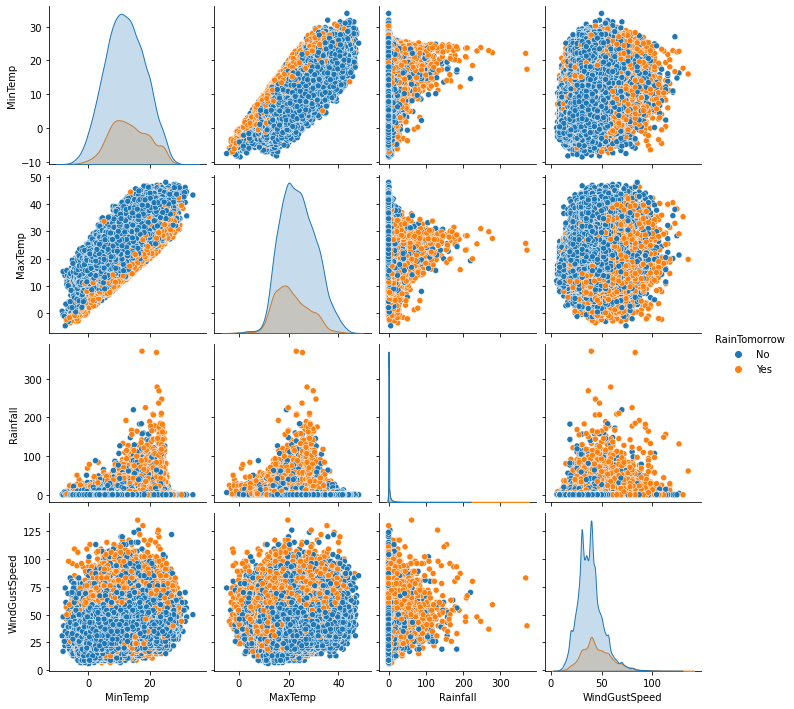

In [80]:
 # check distributions of first 3 numerical values against target (to comapre with the previous plots on original data -we take 3 colums
# because we removed evaporation because a lot of Na:
sns.pairplot(tmp2, vars = tmp2.columns[:4],hue="RainTomorrow")
plt.show()

Distributions are similar to the ones before data cleaning. We have to remember to transoform Rainfall due to outliers and skewed distribution

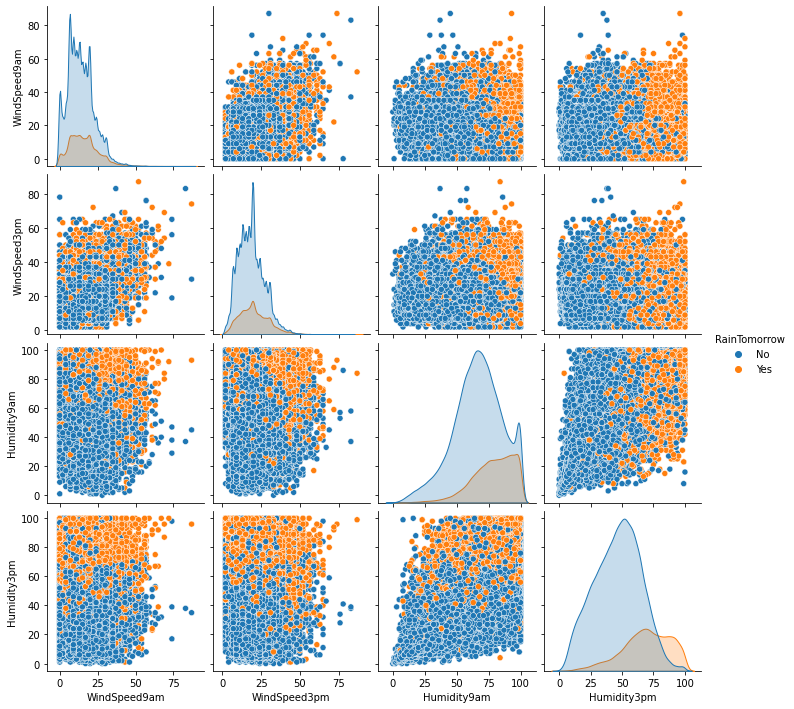

In [81]:
sns.pairplot(tmp2, vars = tmp2.columns[4:8],hue="RainTomorrow")
plt.show()

Distributions are similar to the ones before data cleaning. We have to remember to transoform Humidities due to skewed distribution.
Wind speeds have outliers

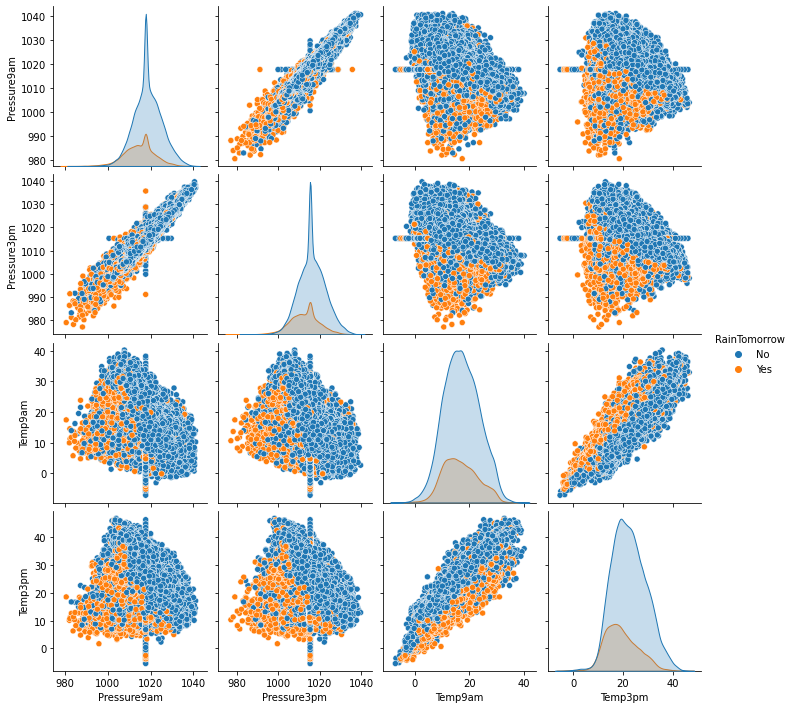

In [82]:
sns.pairplot(tmp2, vars = tmp2.columns[8:12],hue="RainTomorrow")
plt.show()

We see that distributions for Pressures have 'spikes' caused by our inputation of mean value.
To overcome this we should use more sofisticated metod of inputation. We leave it as it is and check how our model will perform.

We don't need to check the Month variable - it  was derived from date and we didn't remove Nan's from this column


Now we check again categorical data

In [83]:
# check the types after data removal:
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

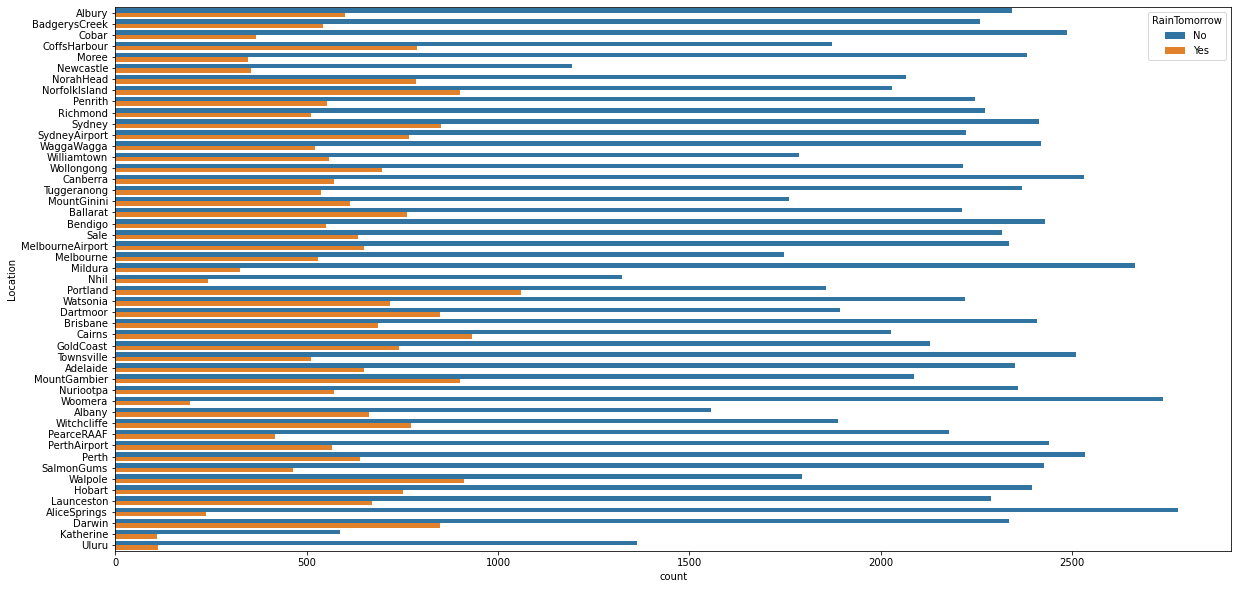

In [84]:
 plt.figure(figsize=(20, 10))
sns.countplot(y = 'Location', hue =  'RainTomorrow', orient = 'v', data = df)

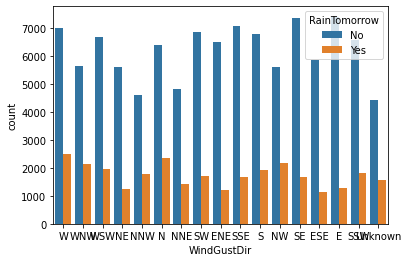

In [85]:
 sns.countplot(x = 'WindGustDir', hue =  'RainTomorrow', orient = 'h', data = df)

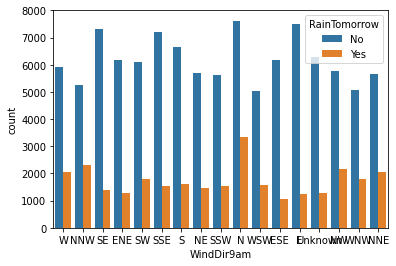

In [86]:
 sns.countplot(x = 'WindDir9am', hue =  'RainTomorrow', orient = 'h', data = df)

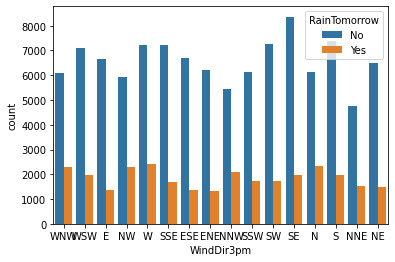

In [87]:
 sns.countplot(x = 'WindDir3pm', hue =  'RainTomorrow', orient = 'h', data = df)

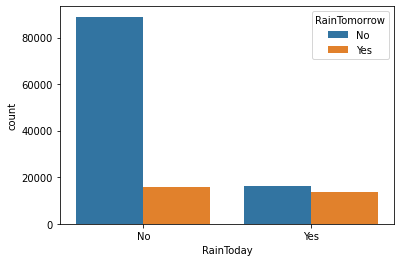

In [88]:
 sns.countplot(x = 'RainToday', hue =  'RainTomorrow', orient = 'h', data = df)

In general distributions of variables is similar to the distribution before data cleaning
Now we can do the encoding and transformations

<h3> Encoding the categorical data </h3>

In [89]:
# replace the string labels with 0 and 1 numbers:
df['RainToday'].replace({'No':0,'Yes':1},inplace = True)
df['RainTomorrow'].replace({'No':0,'Yes':1},inplace = True)

# encode categorical values
categorical = ['WindGustDir','WindDir9am','WindDir3pm','Location']
df = pd.get_dummies(df,columns = categorical,drop_first=True)


In [90]:
df.shape

(134590, 109)

Now we have to deal with the skew distributions in datasets

In [91]:
df.select_dtypes(include=numerics).describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000,134590.000000
mean,12.189509,23.260816,2.314654,40.052862,14.118055,18.816286,68.659744,51.273891,1017.651981,1015.262250,16.978469,21.749529,0.221911,0.219585
std,6.375591,7.062406,8.375341,13.220456,8.832280,8.687083,19.091036,20.754483,6.793114,6.720401,6.471002,6.923049,0.415533,0.413967
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,2.000000,0.000000,0.000000,980.500000,977.100000,-7.200000,-5.400000,0.000000,0.000000
25%,7.600000,18.000000,0.000000,31.000000,7.000000,13.000000,57.000000,36.000000,1013.400000,1011.000000,12.300000,16.700000,0.000000,0.000000
50%,12.000000,22.700000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.653758,1015.258204,16.700000,21.200000,0.000000,0.000000
75%,16.800000,28.200000,0.600000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.900000,1019.500000,21.500000,26.500000,0.000000,0.000000
max,33.900000,48.100000,371.000000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000,1.000000,1.000000


In [92]:
df[skew_var] = tmp3

In [93]:
df.shape

(134590, 109)

<h3> Building the model </h3>

In [94]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [96]:
x = df.drop(labels = ['RainTomorrow'],axis = 1)
x.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm',
       ...
       'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru',
       'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia',
       'Location_Williamtown', 'Location_Witchcliffe', 'Location_Wollongong',
       'Location_Woomera'],
      dtype='object', length=108)

In [97]:
y = df['RainTomorrow']

In [98]:
x = sc.fit_transform(x)

In [99]:
x.shape

(134590, 108)

In [100]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 40)
x_test,x_validation,y_test,y_validation = train_test_split(x_test,y_test,test_size = 0.5,random_state = 40)

In [101]:
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,confusion_matrix,classification_report

In [102]:
def imb_predict(algo,xtrain,ytrain,xtest,ytest):
    
    algo.fit(xtrain,ytrain)
    ypred=algo.predict(xtest)
    yprob=algo.predict_proba(xtest)[:,1]
    
    acc=accuracy_score(ytest,ypred)
    print('Accuracy Score: ',acc)
    
    con = confusion_matrix(ytest,ypred)
    print('Confusion matrix: \n',con)
    
    auc=roc_auc_score(ytest,yprob)
    print('AUC: ',auc)
    
    cr=classification_report(ytest,ypred)
    print('Classification report:\n ',cr)
    
    fpr,tpr,thresh=roc_curve(ytest,yprob)
    plt.plot(fpr,tpr,'b--')
    plt.plot(fpr,fpr,'r--')
    plt.show()  

Accuracy Score:  0.8404497721418664
Confusion matrix: 
 [[15043   662]
 [ 2559  1924]]
AUC:  0.8497487022145921
Classification report:
                precision    recall  f1-score   support

           0       0.85      0.96      0.90     15705
           1       0.74      0.43      0.54      4483

    accuracy                           0.84     20188
   macro avg       0.80      0.69      0.72     20188
weighted avg       0.83      0.84      0.82     20188



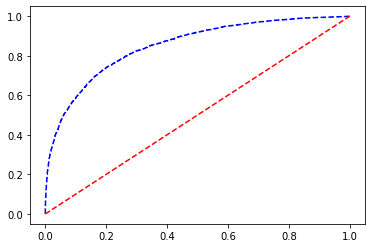

In [103]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

imb_predict(lr,x_train,y_train,x_test,y_test)

<h>**Predicting Accuracy using Linear Regression**</h>

Accuracy Score:  0.8404497721418664
Confusion matrix: 
 [[15043   662]
 [ 2559  1924]]
AUC:  0.8497487022145921
Classification report:
                precision    recall  f1-score   support

           0       0.85      0.96      0.90     15705
           1       0.74      0.43      0.54      4483

    accuracy                           0.84     20188
   macro avg       0.80      0.69      0.72     20188
weighted avg       0.83      0.84      0.82     20188



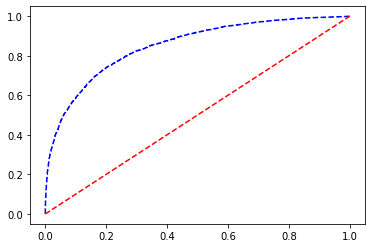

In [104]:
from sklearn.model_selection import cross_val_score
model = LogisticRegression()
imb_predict(model,x_train,y_train,x_test,y_test)

In [105]:
scores = cross_val_score(model, x, y, cv=5)
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.67 accuracy with a standard deviation of 0.04


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Using K-fold Cross Validation

In [108]:
from sklearn.model_selection import ShuffleSplit
n_samples = x.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores=cross_val_score(model, x, y, cv=cv)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [109]:
scores
print("%0.2f accuracy " % (scores.mean()*100))

84.59 accuracy 
